   # Machine Learning Intermediate Project - @ INSAID 

   ## Cancer Cell Detection Using SVM 

<img src="th.jpg"  style = "width:800px;height:300px" />

## Table of Content

1. [Problem Statement](#ProblemStatement)<a href = '#ProblemStatement' ><br>
2. [Data Loading and Description](#section2)<a href = '#section2' ><br>
3. [Exploratory Data Analysis](#section3)<a href = '#section3' ><br>
4. [The Model - SVM](#section4)<a href = '#section4' ><br>
    - 4.1 [Preparing Train and Test data](#section401)<a href = '#section402' ><br>
    - 4.2 [SVM with scikit-learn](#section402)<a href = '#section402' ><br>
    - 4.3 [Using the Model for Prediction](#section403)<a href = '#section402' ><br>
5. [Model evaluation](#section5)<a href = '#section5'>
    - 5.1 [Confusion Matrix](#section501)<a href = '#section501' ><br>
6. [Conclusion](#section6)<a href = '#section6' ><br>

<a id = 'ProblemStatement'> </a>

## 1. Problem Statement

Cancer is the uncontrolled growth of abnormal cells, which do not carry out the functions of normal cells. It starts when cells in the begin to grow out of control. These cells usually form a tumor that can often be seen on an X-ray or felt as a lump.
Early diagnosis significantly increases the chances of surviver. The key challenges against it's detection is how to classify tumors into malignant(Cancer) or benign(not cancer). A tumor is considered malignant (Cancer) if the cells can grow into surrounding tissues or spread to distant areas of the body. A benign tumor does not invade nearby tissue or spread to other parts of the body the way cancer can. But benign tumors can be serious if they press on vital structures such as blood vessel or nerves.
Machine Learning technique can dramatically improve the level of diagnosis in cancer. Research shows that experience physicians can detect cancer by 79% accuracy, while 91%(up to 97%) accuracy can be achieved using Machine Learning techniques.

In this notebook, we will use SVM (Support Vector Machines) to build and train a model using human cell records,
and classify cells to whether the samples are benign or malignant.

<a id = 'section2'> </a>

## 2. Data Loading and Description

The dataset consists of several hundred human cell sample records, each of which contains the values of a set of cell characteristics. The fields in each record are:

|Field name|Description|
|--- |--- |
|ID|Clump thickness|
|Clump|Clump thickness|
|UnifSize|Uniformity of cell size|
|UnifShape|Uniformity of cell shape|
|MargAdh|Marginal adhesion|
|SingEpiSize|Single epithelial cell size|
|BareNuc|Bare nuclei|
|BlandChrom|Bland chromatin|
|NormNucl|Normal nucleoli|
|Mit|Mitoses|
|Class|Benign or malignant|

<br>
<br>

__Importing Packages__

In [39]:
import pandas as pd
import pylab as pl
import numpy as np
import seaborn as sns
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
%matplotlib inline 
import matplotlib.pyplot as plt

#### Importing the Dataset


The example is based on a dataset that is publicly available from the UCI Machine Learning Repository (Asuncion and Newman, 2007)[http://mlearn.ics.uci.edu/MLRepository.html]. 


#### Load Data From CSV File  

In [23]:
#cell_df = pd.read_csv('https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/cell_samples.csv')
cell_df = pd.read_csv("cell_samples.csv")
cell_df.head()

,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


The ID field contains the patient identifiers. The characteristics of the cell samples from each patient are contained in fields Clump to Mit. The values are graded from 1 to 10, with 1 being the closest to benign.

The Class field contains the diagnosis, as confirmed by separate medical procedures, as to whether the samples are benign (value = 2) or malignant (value = 4).

Lets look at the distribution of the classes based on Clump thickness and Uniformity of cell size:

<a id = 'section3'> </a>

## 3. Exploratory Data Analysis

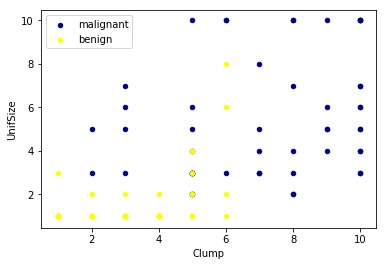

In [24]:
ax = cell_df[cell_df['Class'] == 4][0:50].plot(kind='scatter', x='Clump', y='UnifSize', color='DarkBlue', label='malignant');
cell_df[cell_df['Class'] == 2][0:50].plot(kind='scatter', x='Clump', y='UnifSize', color='Yellow', label='benign', ax=ax);
plt.show()

<a id = 'section4'> </a>

## 4. The Model - SVM 

SVM works by mapping data to a high-dimensional feature space so that data points can be categorized, 
even when the data are not otherwise linearly separable. A separator between the categories is found, 
then the data is transformed in such a way that the separator could be drawn as a hyperplane. 
Following this, characteristics of new data can be used to predict the group to which a new record should belong.

#### Data pre-processing and selection

In [25]:
cell_df.dtypes

ID              int64
Clump           int64
UnifSize        int64
UnifShape       int64
MargAdh         int64
SingEpiSize     int64
BareNuc        object
BlandChrom      int64
NormNucl        int64
Mit             int64
Class           int64
dtype: object

It looks like the __BareNuc__ column includes some values that are not numerical. We can drop those rows:

In [26]:
cell_df = cell_df[pd.to_numeric(cell_df['BareNuc'], errors='coerce').notnull()]
cell_df['BareNuc'] = cell_df['BareNuc'].astype('int')
cell_df.dtypes

ID             int64
Clump          int64
UnifSize       int64
UnifShape      int64
MargAdh        int64
SingEpiSize    int64
BareNuc        int32
BlandChrom     int64
NormNucl       int64
Mit            int64
Class          int64
dtype: object

In [27]:
feature_df = cell_df[['Clump', 'UnifSize', 'UnifShape', 'MargAdh', 'SingEpiSize', 'BareNuc', 'BlandChrom', 'NormNucl', 'Mit']]
X = np.asarray(feature_df)
X[0:5]

array([[ 5,  1,  1,  1,  2,  1,  3,  1,  1],
       [ 5,  4,  4,  5,  7, 10,  3,  2,  1],
       [ 3,  1,  1,  1,  2,  2,  3,  1,  1],
       [ 6,  8,  8,  1,  3,  4,  3,  7,  1],
       [ 4,  1,  1,  3,  2,  1,  3,  1,  1]], dtype=int64)

We want the model to predict the value of Class (that is, benign (=2) or malignant (=4)). As this field can have one of only two possible values, we need to change its measurement level to reflect this.

In [28]:
cell_df['Class'] = cell_df['Class'].astype('int')
y = np.asarray(cell_df['Class'])
y [0:5]

array([2, 2, 2, 2, 2])

<a id = 'section401'> </a>

### 4.1 Preparing Train and Test data

In [29]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (546, 9) (546,)
Test set: (137, 9) (137,)


<a id = 'section402'> </a>

### 4.2 SVM with scikit learn

A Support Vector Machine (SVM) is a binary linear classification whose decision boundary is explicitly constructed to minimize generalization error. It is a very powerful and versatile Machine Learning model, capable of performing linear or nonlinear classification, regression and even outlier detection.

SVM is well suited for classification of complex but small or medium sized datasets.

The SVM algorithm offers a choice of kernel functions for performing its processing. Basically, mapping data into a higher dimensional space is called kernelling. The mathematical function used for the transformation is known as the kernel function, and can be of different types, such as:

    1.Linear
    2.Polynomial
    3.Radial basis function (RBF)
    4.Sigmoid
Each of these functions has its characteristics, its pros and cons, and its equation, but as there's no easy way of knowing which function performs best with any given dataset, we usually choose different functions in turn and compare the results. Let's just use the default, RBF (Radial Basis Function) for this lab.

In [30]:
from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train) 

D:\DATASCIENCE\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

<a id = 'section403'> </a>

### 4.3 Using the model for Prediction

In [31]:
yhat = clf.predict(X_test)
yhat [0:5]

array([2, 4, 2, 4, 2])

<a id = 'section5'> </a>

## 5. Model Evaluation

In [32]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

<a id = 'section501'> </a>

### 5.1 Confusion Matrix 

In [44]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[2,4])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat))


              precision    recall  f1-score   support

           2       1.00      0.94      0.97        90
           4       0.90      1.00      0.95        47

   micro avg       0.96      0.96      0.96       137
   macro avg       0.95      0.97      0.96       137
weighted avg       0.97      0.96      0.96       137



In [45]:
cm = np.array(confusion_matrix(y_test, yhat, labels=[2,4]))
confusion = pd.DataFrame(cm, index=['actual_cancer', 'actual_healthy'],
                         columns=['predicted_cancer','predicted_healthy'])
confusion


,predicted_cancer,predicted_healthy
actual_cancer,85,5
actual_healthy,0,47


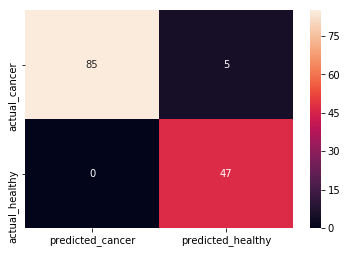

In [46]:
sns.heatmap(confusion, annot=True)

__F1_score__

In [35]:
from sklearn.metrics import f1_score
f1_score(y_test, yhat, average='weighted') 

0.9639038982104676

<a id = 'section6'> </a>

## 6. Conclusion 

Thus , we can say that the SVM model can predict a new cell to be malignant(Cancer) or benign(not cancer) 96% times accurately.
Hence this model can be useful in medical procedures .